# Neural network - Tensorflow 2

# 0. Setup

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from pprint import pprint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from matplotlib import pyplot as plt
tf.random.set_seed(42)

# 1. Load data and normalization

In [2]:
cwd = os.getcwd()
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(
    path = cwd + '/data/mnist.npz'
)

In [3]:
x_train = x_train.reshape(60000, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0

# n_classes = 10
# y_train = tf.keras.utils.to_categorical(y_train.astype('float32'), n_classes)
# y_test = tf.keras.utils.to_categorical(y_test.astype('float32'), n_classes)
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

# 2. Training model using Stochastic Gradient Descent

In [4]:
batch_size = 50
data_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
data_train = data_train.shuffle(buffer_size=1024).batch(batch_size)
data_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
data_val = data_val.batch(batch_size)
data_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
data_test = data_test.batch(batch_size)

In [5]:
class MLP(tf.keras.Model):
    def __init__(self, n_units, n_targets, activation='relu', lamda=0.0, **kwargs):
        super().__init__(**kwargs)
        if type(n_units) is int:
            n_units = [n_units]
        self.feature_extractor = Sequential(
            [Dense(
                unit, 
                activation=activation,
                kernel_initializer='glorot_uniform')    # weight initialization
            for unit in n_units])
        self.last_layer = Dense(
            n_targets, 
            activation='softmax',
            kernel_initializer='glorot_uniform')

    @tf.function
    def call(self, x):
        features = self.feature_extractor(x)
        outputs = self.last_layer(features)
        return outputs

## 2.1. [Using built-in API](https://www.tensorflow.org/guide/keras/train_and_evaluate)

In [6]:
model = MLP(30, 10, lamda=0.01)
model.compile(
    optimizer=RMSprop(learning_rate=.01),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()],
)
print('Fit model on training data')
history = model.fit(
    data_train,
    epochs=30,
    validation_data=data_val,
)

Fit model on training data
Epoch 1/30
 992/1000 [============================>.] - ETA: 0s - loss: 0.4499 - sparse_categorical_accuracy: 0.8662

KeyboardInterrupt: 

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


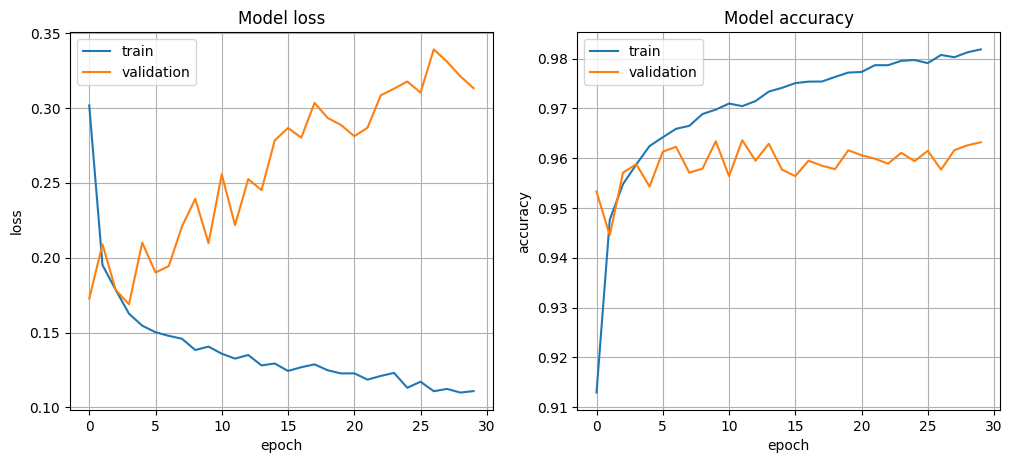

In [30]:
print(history.history.keys())
plt.figure(figsize=(12, 5), dpi=100)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.grid(True)
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')

## 2.2. [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/)